# Analyse Morris results

In [1]:
import pandas as pd
import seaborn as sns
import re

/tmp/ipykernel_16477/2044394985.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Run with `dakota -i ia.in > morris_summary.out`: only `>` gets results written to file.

In [2]:
# Must be am easier way to get Dakota results out...
# Read in .out file (contains summary results)

output_files = ["morris_lt_summary.out", "morris_lt_max_net_elec_summary.out"]

# Match line in output
input_re = re.compile(r"Input\s+(\d+)\s.*=\s+(\d+\.\d+e[+-]\d+)\s+(\d+\.\d+e[+-]\d+)")
end_of_results_re = re.compile(r"^$")
results = {"design": [], "input": [], "descriptor": [], "mod_mean": [], "std": []}

descriptors = [
    "fdene",
    "hfact",
    "coreradius",
    "fimp_2",
    "fimp_14",
    "psepbqarmax",
    "flhthresh",
    "cboot",
    "peakfactrad",
    "kappa",
    "etaech",
    "feffcd",
    "etath",
    "etaiso",
    "boundl_18",
    "pinjalw",
    "alstroh",
    "sig_tf_wp_max",
    "aspect",
    "boundu_2",
    "triang",
]

for output_file in output_files:
    design_and_suffix = output_file.split("morris_")[1]
    design = design_and_suffix.split("_summary.out")[0]
    with open(output_file, "r") as f:
        content = f.readlines()

    got_results = False
    for line in content:
        if matches := input_re.match(line):
            got_results = True
            # Start of results
            results["design"].append(design)
            results["input"].append(float(matches[1]))
            # TODO Improve this! Risk of descriptors and input number getting out of sync
            results["descriptor"].append(descriptors[int(matches[1]) - 1])
            results["mod_mean"].append(float(matches[2]))
            results["std"].append(float(matches[3]))
        elif got_results and end_of_results_re.match(line):
            # Got first set of results (w), ignore others (individual constraints), now exit
            break
        else:
            continue

results_df = pd.DataFrame(results)
results_df

,design,input,descriptor,mod_mean,std
0,lt,1.0,fdene,0.000000,0.000000
1,lt,2.0,hfact,0.000000,0.000000
2,lt,3.0,coreradius,0.000000,0.000000
3,lt,4.0,fimp_2,0.000000,0.000000
4,lt,5.0,fimp_14,0.790550,0.909250
5,lt,6.0,psepbqarmax,0.000000,0.000000
6,lt,7.0,flhthresh,0.271700,0.363530
7,lt,8.0,cboot,0.168370,0.389250
8,lt,9.0,peakfactrad,0.000000,0.000000
9,lt,10.0,kappa,0.318100,0.508460


Text(0, 0.5, '$\\sigma$')

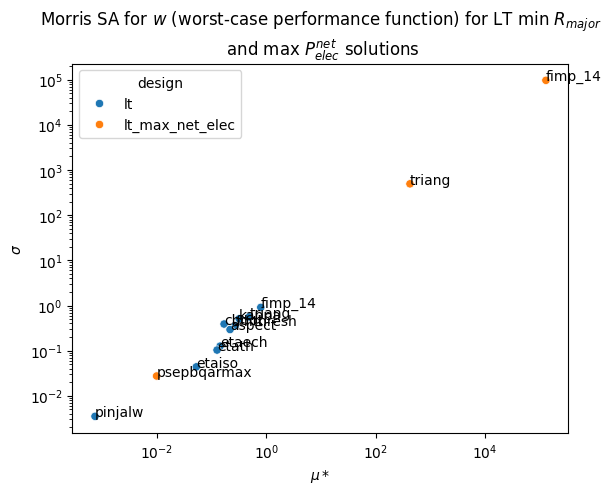

In [3]:
# Plot both designs together
ax = sns.scatterplot(data=results_df, x="mod_mean", y="std", hue="design")

x_offset = 0.0
y_offset = 0.0


def label_point(df):
    for _, row in df.iterrows():
        mod_mean = row["mod_mean"]
        std = row["std"]
        # Only label if not 0: avoid overwriting at same point
        if mod_mean != 0.0 and std != 0.0:
            ax.annotate(text=row["descriptor"], xy=(mod_mean, std))


ax.loglog()
label_point(results_df)

ax.set_title(
    "Morris SA for $w$ (worst-case performance function) for LT min $R_{major}$\n"
    " and max $P_{elec}^{net}$ solutions"
)
ax.set_xlabel("$\mu*$")
ax.set_ylabel("$\sigma$")

Text(0, 0.5, '$\\sigma$')

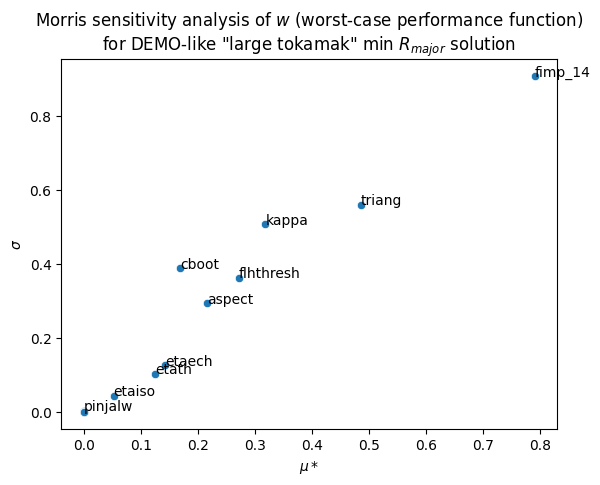

In [4]:
# min rmajor only
lt_results_df = results_df[results_df["design"] == "lt"]
ax = sns.scatterplot(data=lt_results_df, x="mod_mean", y="std")

# ax.loglog()
label_point(lt_results_df)

ax.set_title(
    "Morris sensitivity analysis of $w$ (worst-case performance function)\n"
    'for DEMO-like "large tokamak" min $R_{major}$ solution'
)
ax.set_xlabel("$\mu*$")
ax.set_ylabel("$\sigma$")

Text(0, 0.5, '$\\sigma$')

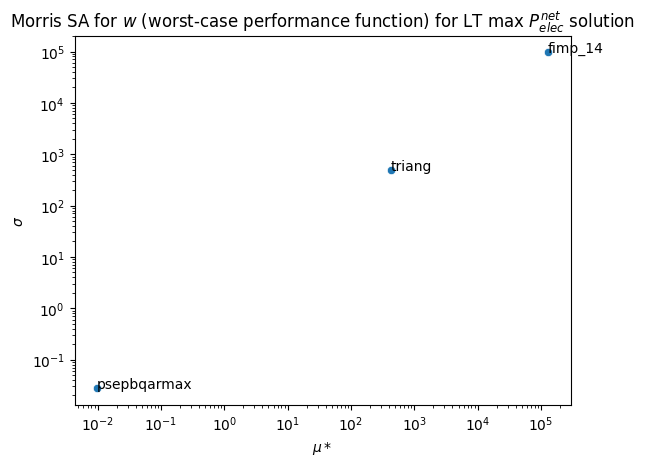

In [5]:
# Max P net elec only
lt_max_net_elec_results_df = results_df[results_df["design"] == "lt_max_net_elec"]
ax = sns.scatterplot(
    data=lt_max_net_elec_results_df,
    x="mod_mean",
    y="std",
)

ax.loglog()
label_point(lt_max_net_elec_results_df)

ax.set_title(
    "Morris SA for $w$ (worst-case performance function) for LT max $P_{elec}^{net}$ solution"
)
ax.set_xlabel("$\mu*$")
ax.set_ylabel("$\sigma$")

## Individual constraint analysis

In [14]:
# Read in individual evaluations
# evals = pd.read_csv("morris_lt.dat", sep="\s+")
# evals_described = evals.describe()
# evals_w_sorted = evals.sort_values(by="w", ascending=False)
# Nothing too badly violated

evals = pd.read_csv("morris_lt_max_net_elec.dat", sep="\s+")
# Drop interface column; str and not useful
evals.drop(labels="interface", axis=1, inplace=True)

# Describe responses
responses_re = r"(^w$|eq_con\d{3})"
parameters_re = r"^(?!(w$|\w*eq_con\d{3}))"
responses = evals.filter(regex=responses_re)
responses.describe()

,w,eq_con001,eq_con002,eq_con011,ineq_con005,ineq_con008,ineq_con009,ineq_con013,ineq_con015,ineq_con030,...,ineq_con035,ineq_con036,ineq_con060,ineq_con062,ineq_con065,ineq_con072,ineq_con081,ineq_con068,ineq_con031,ineq_con032
count,506.000000,506.000000,506.000000,5.060000e+02,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,...,5.060000e+02,5.060000e+02,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,5.060000e+02,506.000000
mean,51112.506722,-0.003802,0.012701,5.062617e-14,-0.003353,-0.361570,-0.010294,0.058699,51112.462322,-1.487501,...,6.198942e-10,-1.496836e-01,0.004484,0.043220,-2.105665,-0.000028,-0.672948,-56933.667452,-1.419900e-10,-0.156537
std,64343.503131,0.011199,0.021997,6.317133e-30,0.040716,0.031724,0.019892,0.077514,64343.538470,0.201240,...,1.034999e-25,2.778304e-17,0.002078,0.032734,0.025884,0.000701,0.091190,71784.187539,2.587497e-26,0.000000
min,0.016801,-0.019515,-0.029159,5.062617e-14,-0.054914,-0.408311,-0.039953,-0.084183,-0.205706,-1.666667,...,6.198942e-10,-1.496836e-01,0.001912,-0.018128,-2.140465,-0.000964,-0.790011,-155025.531000,-1.419900e-10,-0.156537
25%,0.194874,-0.014837,-0.002670,5.062617e-14,-0.054914,-0.388587,-0.025388,0.006899,0.194874,-1.666667,...,6.198942e-10,-1.496836e-01,0.002356,0.009217,-2.140465,-0.000964,-0.790011,-144370.786600,-1.419900e-10,-0.156537
50%,2.158194,-0.004983,0.016443,5.062617e-14,-0.017586,-0.360787,-0.008759,0.064448,2.158194,-1.509575,...,6.198942e-10,-1.496836e-01,0.005548,0.051616,-2.093684,0.000286,-0.637849,-2.569589,-1.419900e-10,-0.156537
75%,131792.840900,0.007981,0.032229,5.062617e-14,0.047855,-0.331397,0.007603,0.119963,131792.840900,-1.234801,...,6.198942e-10,-1.496836e-01,0.006918,0.080176,-2.074946,0.000811,-0.559513,-0.295724,-1.419900e-10,-0.156537
max,132474.901200,0.012820,0.047509,5.062617e-14,0.047855,-0.312750,0.021502,0.175071,132474.901200,-1.186164,...,6.198942e-10,-1.496836e-01,0.006918,0.083372,-2.074946,0.000811,-0.559513,0.172501,-1.419900e-10,-0.156537


Looks like `ineq_con015` is the one with the huge violation value. Find programmatically:

In [12]:
# Find constraint that is w (worst violated)
print(
    "Worst-violated constraint: "
    # Returns [w, constraint_name]
    + responses.columns[responses.eq(responses["w"].max()).any(axis=0)][1]
    + " = "
    + str(responses["w"].max())
)

# Find parameters causing max w
# Find rows containing max w, then filter for parameter columns only
max_w_rows = evals[responses.eq(responses["w"].max()).any(axis=1)].filter(
    regex=parameters_re
)
# Which parameters are staying constant?
# eyeballing: fimp_14 and triang always look similar in max w case
# Use mean-normalised std
max_w_rows.loc[:, max_w_rows.std() / max_w_rows.mean() < 0.01].describe()
max_w_rows.loc[:, max_w_rows.std() / max_w_rows.mean() < 0.01]

Worst-violated constraint: ineq_con015 = 132474.9012


,fimp_14,triang
16,0.0001,0.4
17,0.0001,0.4
18,0.0001,0.4
19,0.0001,0.4
20,0.0001,0.4
21,0.0001,0.4
74,0.0001,0.4
75,0.0001,0.4
76,0.0001,0.4
77,0.0001,0.4


High fimp_14 and low triang cause the max w value (high constraint violation). Check row 16 (run 17 in Dakota). Constraint 15 ~1e5.
```
(plhthresh)___________________      1.3247590122539455E+02 OP
(pdivt)_______________________      1.0000000000000000E-03 OP
```
plhthresh is reasonable (131 MW), but pdivt is very low. Currently resting on a kludge. Reason for high violation of constraint 15, and hence high $w$.